In [26]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

### Readin Data

In [2]:
full = pd.read_parquet('../data/curated/train_data/')
full = full.rename({'y_total_num_consumer': 'next_total_num_consumer', 'y_total_revenue': 'next_total_revenue', 'y_total_num_transaction': 'next_total_num_transaction'}, axis = 1)
full.dtypes

merchant_abn                    int64
total_num_consumer              int64
avg_dollar_value              float64
total_num_transaction           int64
mean_income                   float64
revenue_level                  object
total_revenue                 float64
total_num_postcode              int64
tag                            object
next_total_num_consumer       float64
next_total_revenue            float64
next_total_num_transaction    float64
dtype: object

### Data Preprocessing

In [3]:
# drop the columns not needed
consumer_df = full[['tag', 'total_num_consumer', 'total_num_transaction', 'next_total_num_consumer']]
consumer_df

,tag,total_num_consumer,total_num_transaction,next_total_num_consumer
0,furniture,808,823,980.0
1,cable,731,750,918.0
2,music,107,107,107.0
3,gift,2244,2370,2662.0
4,computer,130,130,161.0
...,...,...,...,...
3948,hobby,206,207,94.0
3949,cable,77,77,92.0
3950,digital goods,1464,1506,1669.0
3951,opticians,3920,4285,4614.0


In [4]:
# change tags into numeric feature by one hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
tag_ohe = enc.fit_transform([[i] for i in consumer_df['tag']]).toarray()
tag_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
consumer_df[enc.categories_[0]] = tag_ohe
consumer_df = consumer_df.dropna()
consumer_df

/tmp/ipykernel_10677/3763590249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_df[enc.categories_[0]] = tag_ohe
/tmp/ipykernel_10677/3763590249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_df[enc.categories_[0]] = tag_ohe
/tmp/ipykernel_10677/3763590249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,tag,total_num_consumer,total_num_transaction,next_total_num_consumer,antique,art dealer,artist supply,bicycle,books,cable,...,hobby,jewelry,motor,music,opticians,shoe,stationery,telecom,tent,watch
0,furniture,808,823,980.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cable,731,750,918.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,music,107,107,107.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gift,2244,2370,2662.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,computer,130,130,161.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,hobby,206,207,94.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,cable,77,77,92.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,digital goods,1464,1506,1669.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3951,opticians,3920,4285,4614.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Visualisation

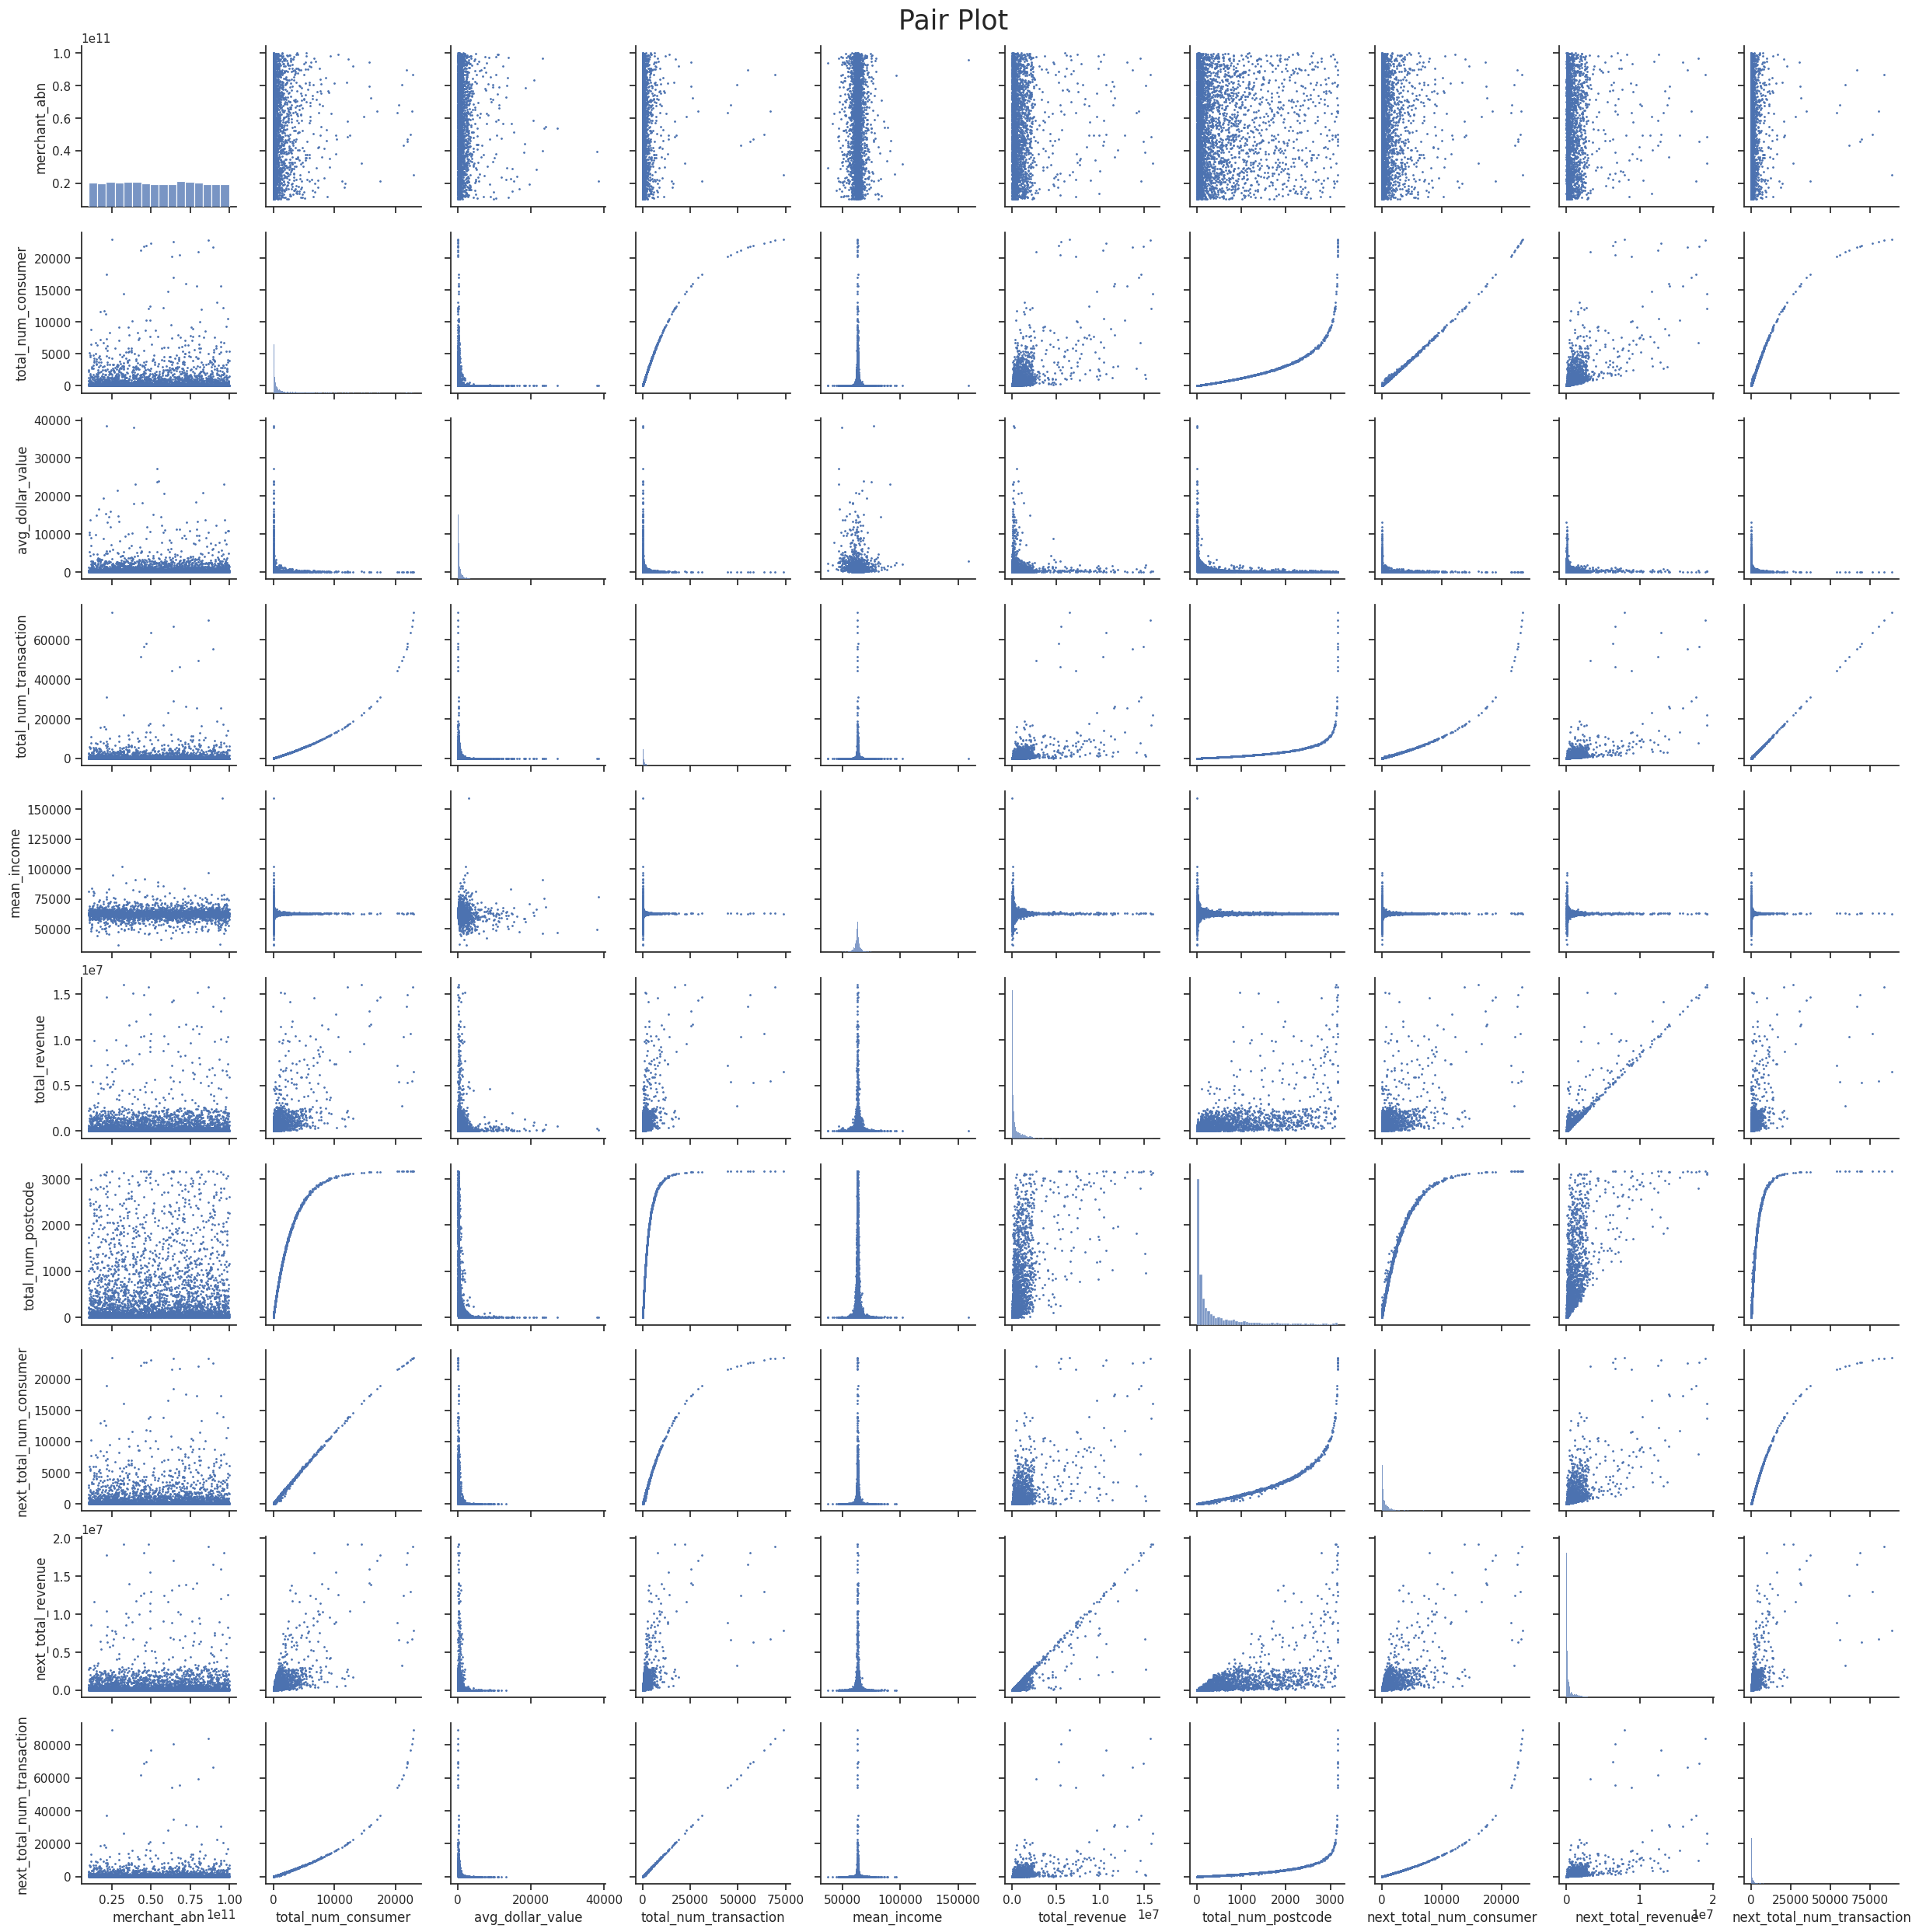

In [37]:
import seaborn as sbs
import matplotlib.pyplot as plt
x_axis = ['Merchant ABN', "Total num Consumer", "Average Dollar Value", "Total num Transaction", "Mean Income", "Total Revenue", "Total num Postcode", "Next Total num Consumer", "Next Total Revenue", "Next Total num Transaction"]
sbs.set(style="ticks", color_codes=True)
g = sbs.pairplot(full, plot_kws=dict(s=1, edgecolor="b", linewidth=1))
g.fig.suptitle("Pair Plot", y = 1, size = 25)
g.fig.savefig("../plots/Pair Plot for all features.jpg")
plt.show()

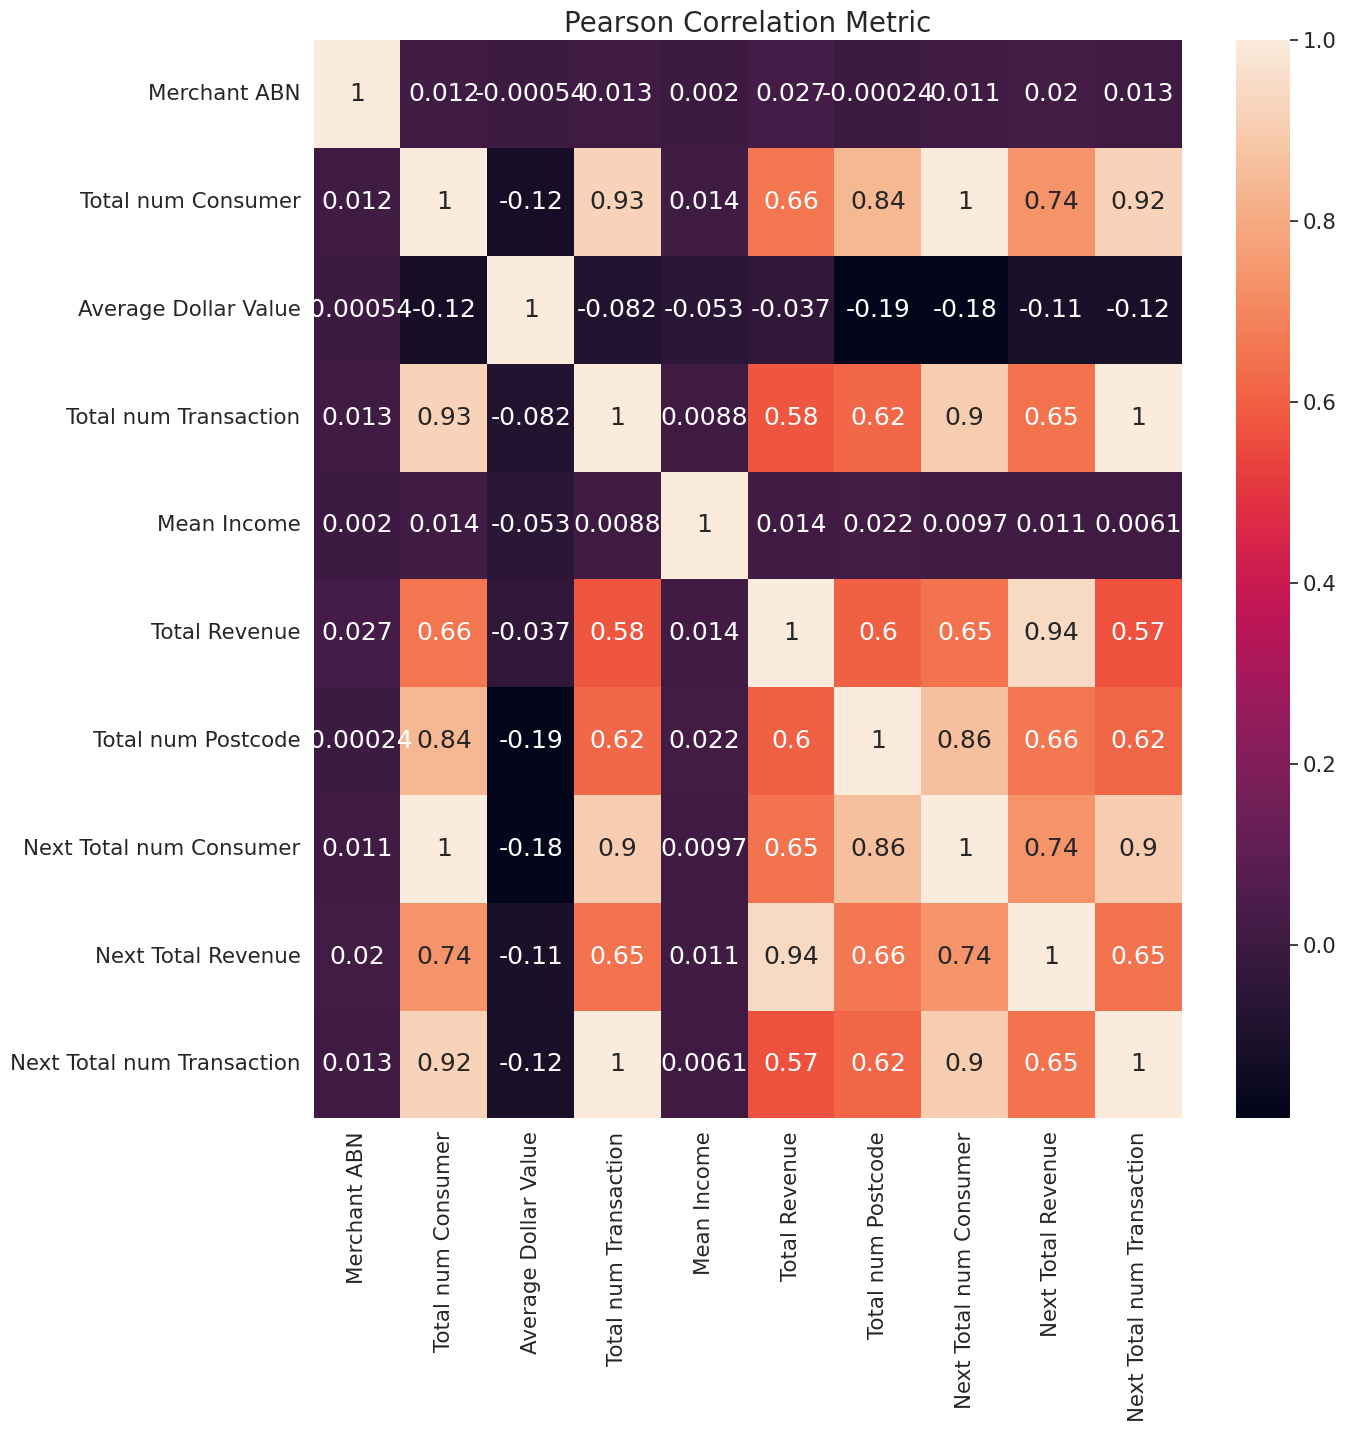

In [35]:
sbs.set(font_scale=1.4)
plt.figure(figsize = (14, 14))
sbs.heatmap(full.corr(), annot = True,annot_kws={"size": 18}, xticklabels=x_axis, yticklabels=x_axis)
plt.title('Pearson Correlation Metric', size = 20)
plt.savefig("../plots/Pearson Correlation Metric")

### Linear Regression

In [11]:
features = ['total_num_consumer', 'total_num_transaction']
X = np.array(consumer_df[features])
y = np.array(consumer_df['next_total_num_consumer'])
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9990051052648128

In [12]:
# missing values will not be included
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
lr = LinearRegression()
fitted_model = lr.fit(X_train, y_train)
fitted_model.score(X_test, y_test)

0.9990606556153125

In [14]:
print("Coefficients: %s" % str(fitted_model.coef_))
print("Intercept: %s" % str(fitted_model.intercept_))

Coefficients: [ 1.2548567  -0.07955785]
Intercept: -2.275846064876532


In [16]:
lr_predictions = fitted_model.predict(X_test)
lr_predictions

array([2.24291389e+03, 1.24656430e+02, 1.25005048e+00, ...,
       4.86241662e+03, 2.12301309e+01, 4.08919635e+02])

In [18]:
show_result = pd.DataFrame({'y_pred': lr_predictions, 'y_true': y_test})
show_result

,y_pred,y_true
0,2242.913887,2332.0
1,124.656430,145.0
2,1.250050,3.0
3,229.098911,155.0
4,644.916030,627.0
...,...,...
1131,60.014993,71.0
1132,899.717206,861.0
1133,4862.416618,4977.0
1134,21.230131,21.0


In [21]:
print("r2 score: ", r2_score(lr_predictions, y_test))
print("Mean Absolute Error: ", mean_absolute_error(lr_predictions, y_test))

r2 score:  0.9990730702499282
Mean Absolute Error:  32.92475594779884


### Neural Network

In [22]:
consumer_df

,tag,total_num_consumer,total_num_transaction,next_total_num_consumer,antique,art dealer,artist supply,bicycle,books,cable,...,hobby,jewelry,motor,music,opticians,shoe,stationery,telecom,tent,watch
0,furniture,808,823,980.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cable,731,750,918.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,music,107,107,107.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gift,2244,2370,2662.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,computer,130,130,161.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,hobby,206,207,94.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,cable,77,77,92.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,digital goods,1464,1506,1669.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3951,opticians,3920,4285,4614.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
consumer_df = consumer_df.drop(columns = 'tag')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(consumer_df.loc[:, consumer_df.columns != 'next_total_num_consumer'], consumer_df['next_total_num_consumer'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((2648, 26), (1136, 26))

In [27]:
# scale train and test dataset in order to be standard normally distributed with zero mean
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)
X_trainscaled.shape, X_testscaled.shape

((2648, 26), (1136, 26))

In [28]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(128,128,128,128),activation="relu" ,solver = 'adam', random_state=30034, max_iter=20000)\
    .fit(X_trainscaled, y_train)
y_pred=mlp_reg.predict(X_testscaled)
print("The Score with ", (metrics.r2_score(y_pred, y_test)))

The Score with  0.9986929058268609


In [29]:
df_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_result.head()

,Actual,Predicted
558,2332.0,2312.310245
546,145.0,73.853151
2308,3.0,25.314389
2996,155.0,172.432815
807,627.0,685.279623


In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 36.50508002212065
Mean Squared Error: 0.9987212705319911
